In [ ]:
# # IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# # RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()


In [ ]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# hw_2_p_2_face_verification_fall_2025_path = kagglehub.competition_download('11785-hw-2-p-2-face-verification-fall-2025')

# print('Data source import complete.')


# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Schedule:
- Checkpoint Submission (DUE 03 October 2025 @ 11:59PM EST)
- Kaggle Submission (DUE 10 October 2025 @ 11:59PM EST | Slack Deadline is 17 October 2025 @ 11:59PM EST)
- Code Submission (DUE 12 October 2025 @ 11:59PM EST OR Day-of Slack submission)


## Requirement Acknowledgement
Setting the below flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. We will require your kaggle username here, and then we will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.

In [ ]:
ACKNOWLEDGED = True #TODO: Only set Acknowledged to True if you have read the above acknowlegements and agree to ALL of them.

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Thu Oct 16 01:39:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Welcome to the World of Convolutions!
In the previous homework, you learned about Multi-Layer Perceptrons (MLPs), the foundation of deep learning. MLPs demonstrated how networks could learn to predict phonemes from speech data, understand patterns, and even approximate complex functions. However, as powerful as MLPs are, they can struggle when dealing with image data. Flattening images into 1D vectors loses spatial information, like how pixels relate to one another. That’s where Convolutional Neural Networks (CNNs) step in, preserving these relationships and taking us one step closer to designing models that "see" the world as we do.

In this homework, you’ll explore CNNs by working on face classification and verification tasks. Imagine training a model to identify a face from a set of known identities (classification) and then using the same model to decide whether two face images belong to the same person (verification).

For example, given a photo of your friend and a group photo, the classifier would identify your friend’s name, while the verifier would confirm whether two photos depict the same person, even if the person wasn’t part of the training data. CNNs make this possible by extracting hierarchical features from images—from edges and corners in early layers to complex patterns like facial features in deeper layers.

To succeed, you’ll need to understand the nuances of loss functions. Classification relies on Cross-Entropy Loss, which optimizes the model to predict the correct label. For verification, however, we care about embedding similarity. This is where Triplet Loss or** ArcFace Loss** comes in, pushing embeddings of the same person closer together while separating those of different individuals. For instance, a good verification system would ensure that photos of two siblings (often visually similar) are distinguishable in the embedding space, all while being robust to lighting or pose differences.

This homework will also emphasize the practical skills needed for real-world deep learning. You’ll preprocess images, apply data augmentation like flipping or cropping to make the model robust to shifts in the images, and experiment with CNN architectures such as ResNet or ConvNeXt. Along the way, you’ll see how designing a model for classification doesn’t automatically make it suitable for verification, teaching you the importance of aligning task objectives with the right loss function. By the end, you’ll have built a robust system that mimics cutting-edge face recognition applications, from unlocking smartphones to verifying IDs. Let’s take this exciting leap together!

# **SET-UP**


Join the kaggle competition first (https://www.kaggle.com/t/93e12fee620b40d7a82990b9fe1815c7)

## **Colab Users**

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Thu Oct 16 01:39:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content
!pwd

/content
/content


In [ ]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet # Install the Pytorch Metric Library
!pip install torchinfo --quiet # Install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 4.2 MB/s eta 0:00:00


Get Data

In [ ]:
# TODO: Use the same Kaggle code from HW2P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2 --quiet
!rm -rf /root/.kaggle
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"shivamdesai05","key":"e0ea407cb198d35c83affd64cf39df45"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 5.2 MB/s eta 0:00:00


In [ ]:
!ls dir of your data

ls: cannot access 'dir': No such file or directory
ls: cannot access 'of': No such file or directory
ls: cannot access 'your': No such file or directory
ls: cannot access 'data': No such file or directory


In [ ]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2025
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2025.zip' -d '/content/data'

## **Kaggle Users**



#### Step 1: Environment Setup

In [ ]:
# !pwd

In [ ]:
# !pip install wandb --quiet # Install WandB
# !pip install pytorch_metric_learning --quiet # Install the Pytorch Metric Library
# !pip install torchinfo --quiet # Install torchinfo

#### Step 2: Get Data

If you are using Kaggle, follow these steps to add the dataset directly to your notebook:
1. Join the kaggle competition (https://www.kaggle.com/t/93e12fee620b40d7a82990b9fe1815c7)
2. Open your **Kaggle Notebook**.  
3. Navigate to **Notebook → Input**.  
4. Click **Add Input**.  
5. Choose "Competition Datasets" and "Your work", and then you'll be able to see the competiation "11785-hw-2-p-2-face-verification-fall-2025"
6. Click the **➕ (plus sign)** to add the dataset to your notebook.  

## **PSC Users**

### 1️⃣ **Step 1 Setting Up Your Environment on Bridges2**

❗️⚠️ For this homework, we are **providing shared Datasets and a shared Conda environment** for the entire class.

❗️⚠️ So for PSC users, **do not download the data yourself** and **do not need to manually install the packages**!

Follow these steps to set up the environment and start a Jupyter notebook on Bridges2:

To run your notebook more efficiently on PSC, we need to use a **Jupyter Server** hosted on a compute node.

You can use your prefered way of connecting to the Jupyter Server.



**The recommended way of connecting is:**

#### **Connect in VSCode**
SSH into Bridges2 and navigate to your **Jet directory** (`Jet/home/<your_username>`). Upload your notebook there, and then connect to the Jupyter Server from that directory.

#### **1. SSH into Bridges2**
1）Open VS Code and click on the `Extensions` icon in the left sidebar. Make sure the "**Remote - SSH**" extension is installed.

2）Open the command palette (**Shift+Command+P** on Mac, **Ctrl+Shift+P** on Windows). A search box will appear at the top center. Choose `"Remote-SSH: Add New SSH Host"`, then enter:

```bash
ssh <your_username>@bridges2.psc.edu #change <your_username> to your username
```

Next, choose `"/Users/<your_username>/.ssh/config"` as the config file. A dialog will appear in the bottom right saying "Host Added". Click `"Connect"`, and then enter your password.

(Note: After adding the host once, you can later use `"Remote-SSH: Connect to Host"` and select "bridges2.psc.edu" from the list.)

3）Once connected, click `"Explorer"` in the left sidebar > "Open Folder", and navigate to your home directory under the project grant:
```bash
/jet/home/<your_username>  #change <your_username> to your username
```

4）You can now drag your notebook files directly into the right-hand pane (your remote home directory), or upload them using `scp` into your folder.

> ❗️⚠️ The following steps should be executed in the **VSCode integrated terminal**.

#### **2. Navigate to Your Directory**
Make sure to use this `/jet/home/<your_username>` as your working directory, since all subsequent operations (up to submission) are based on this path.
```bash
cd /jet/home/<your_username>  #change <your_username> to your username
```

#### **3. Request a Compute Node**
```bash
interact -p GPU-shared --gres=gpu:v100-32:1 -t 8:00:00 -A cis250019p
```

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import os
import gc
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv
import math
import torch.nn as nn
import torch.nn.functional as F
import random

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


# Config

### Notes:

- You will need to set the root path to your `hw2p2_data` folder in `data: root:`. This will depend on your setup. For eg. if you are following out setup instruction:
  - `Colab:`: `"/content/data/hw2p2_puru_aligned"`
  - `Kaggle:`: `"/kaggle/input/11785-hw-2-p-2-face-verification-fall-2025/hw2p2_puru_aligned"`
  - `PSC`: `"/ocean/projects/cis250019p/mzhang23/TA/HW2P2/hw2p2_data/hw2p2_puru_aligned"`

Kindly modify your configurations to suit your ablations and be keen to include your name.

In [ ]:
config = {
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 21,                   # Optimized for 25 epochs
    'num_classes': 8631,


    # Paths
    'cls_data_dir': "/content/data/hw2p2_puru_aligned/cls_data",
    'ver_data_dir': "/content/data/hw2p2_puru_aligned/ver_data",
    'val_pairs_file': "/content/data/hw2p2_puru_aligned/val_pairs.txt",
    'test_pairs_file': "/content/data/hw2p2_puru_aligned/test_pairs.txt",
    'checkpoint_dir': "/content/checkpoints",

    # Training parameters
    'weight_decay': 0.005,
    'augument': True
}


print("Config:")



Config:


# Dataset

In [ ]:
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    transform_list = [
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.ToDtype(torch.float32, scale=True),
    ]

    if augment:
        transform_list.extend([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=15),
            T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.03),
            T.RandomGrayscale(p=0.1),
            T.RandomErasing(p=0.3, scale=(0.02, 0.2)),
        ])

    transform_list.append(T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))

    return T.Compose(transform_list)

## Classification Datasets and Dataloaders

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

0

In [ ]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])

# val transforms
val_transforms   = create_transforms(augment=False)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# Datasets
cls_train_dataset = ImageDataset(
    root=os.path.join(config['cls_data_dir'], "train"),
    transform=create_transforms(image_size=112, augment=config['augument'])
)

cls_val_dataset = ImageDataset(
    root=os.path.join(config['cls_data_dir'], "dev"),
    transform=create_transforms(image_size=112, augment=False)
)

cls_test_dataset = ImageDataset(
    root=os.path.join(config['cls_data_dir'], "test"),
    transform=create_transforms(image_size=112, augment=False)
)

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"



# Dataloaders
cls_train_loader = DataLoader(cls_train_dataset, batch_size=config['batch_size'], shuffle=True,  num_workers=4, pin_memory=True)
cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

Loading dataset:   0%|          | 0/431550 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/43155 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/43155 [00:00<?, ?it/s]

## Verification Dataset and Datatloaders

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [ ]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [ ]:
ver_val_dataset = ImagePairDataset(
    root=config['ver_data_dir'],
    pairs_file=config['val_pairs_file'],
    transform=create_transforms(image_size=112, augment=False)
)

ver_test_dataset = TestImagePairDataset(
    root=config['ver_data_dir'],
    pairs_file=config['test_pairs_file'],
    transform=create_transforms(image_size=112, augment=False)
)

# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)


Loading image pairs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading image pairs:   0%|          | 0/6000 [00:00<?, ?it/s]

## Create Dataloaders for Image Recognition

# EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  128
Train batches        :  3372
Val batches          :  338


###Classification Dataset Viz

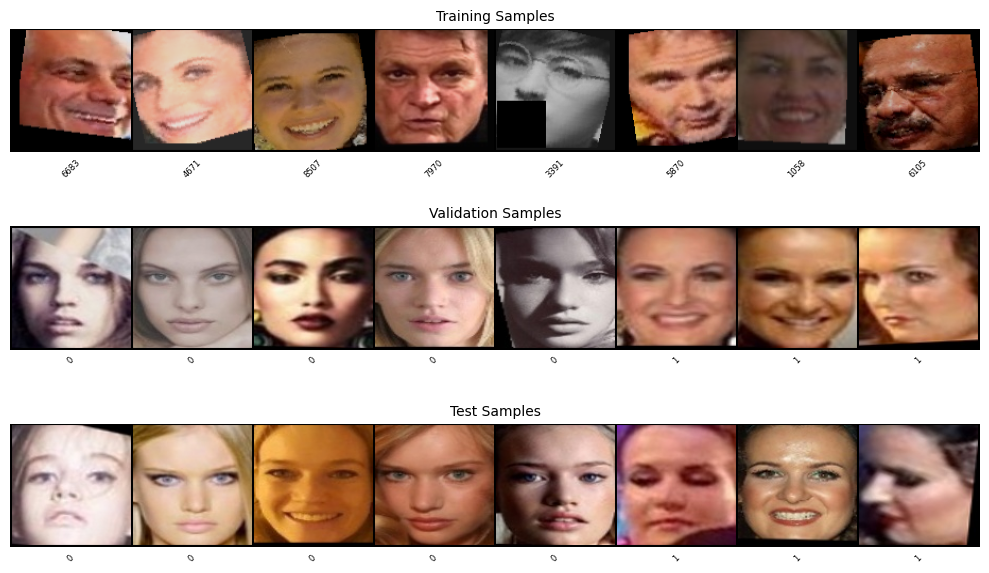

In [ ]:
def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()

show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

###Ver Dataset Viz

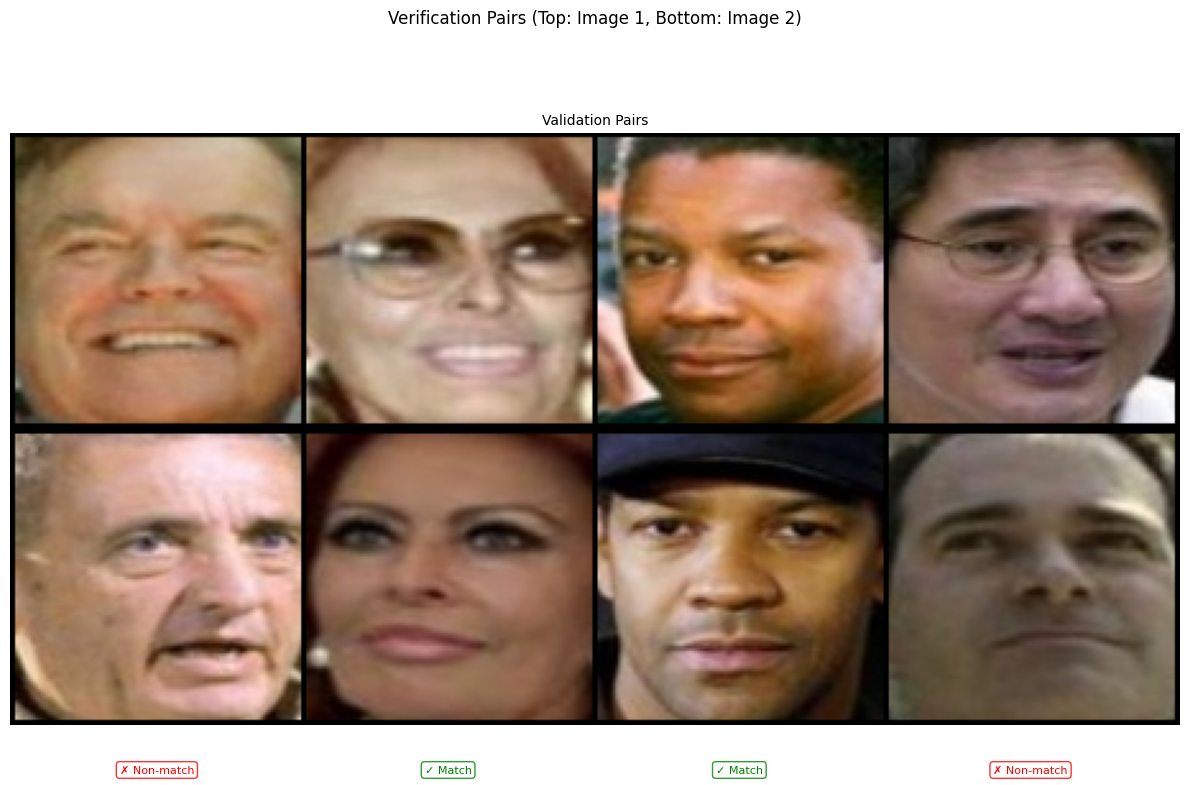

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)


# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# TODO: Fill out the model definition below
class StochasticDepth(nn.Module):
    def __init__(self, drop_rate):
        super().__init__()
        self.drop_rate = drop_rate

    def forward(self, x):
        if not self.training or self.drop_rate == 0:
            return x

        keep_prob = 1 - self.drop_rate
        # Create random tensor with same batch size
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # Binarize
        return x.div(keep_prob) * random_tensor

class MBConv(nn.Module):
    def __init__(self, inp, oup, stride=1, expand_ratio=4, drop_rate=0):
        super().__init__()
        self.stride = stride
        self.use_residual = stride == 1 and inp == oup
        hidden_dim = int(inp * expand_ratio)

        if expand_ratio != 1:
            self.expand = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(inplace=True)
            )
        else:
            self.expand = None

        self.depthwise = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),
        )

        self.project = nn.Sequential(
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup)
        )

        self.stochastic_depth = StochasticDepth(drop_rate)

    def forward(self, x):
        identity = x

        if self.expand is not None:
            x = self.expand(x)

        x = self.depthwise(x)
        x = self.project(x)

        if self.use_residual:
            # THIS IS THE KEY FIX - actually use stochastic depth
            return identity + self.stochastic_depth(x)
        return x

In [ ]:
class Network(torch.nn.Module):
    def __init__(self, num_classes=8631, embedding_size=512, width_mult=0.9):
        super().__init__()
        self.embedding_size = embedding_size

        # Stem
        self.layer_in = nn.Sequential(
            nn.Conv2d(3, int(48 * width_mult), 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(int(48 * width_mult)),
            nn.SiLU(inplace=True),
        )

        # Progressive drop rates for stochastic depth
        total_blocks = 4 + 6 + 4 + 4
        drop_rates = [i * 0.15 / total_blocks for i in range(total_blocks)]

        # Stages with PROGRESSIVE expand ratios (not all 4)
        idx = 0
        self.stage1 = self._make_stage(
            int(48 * width_mult), int(96 * width_mult),
            1, 2, 4, drop_rates[idx:idx+4]  # expand_ratio=2
        )
        idx += 4

        self.stage2 = self._make_stage(
            int(96 * width_mult), int(192 * width_mult),
            2, 3, 6, drop_rates[idx:idx+6]  # expand_ratio=3
        )
        idx += 6

        self.stage3 = self._make_stage(
            int(192 * width_mult), int(384 * width_mult),
            2, 4, 4, drop_rates[idx:idx+4]  # expand_ratio=4
        )
        idx += 4

        self.stage4 = self._make_stage(
            int(384 * width_mult), int(768 * width_mult),
            2, 4, 4, drop_rates[idx:idx+4]  # expand_ratio=4
        )

        # Head with dropout
        self.layer_out = nn.Sequential(
            nn.Conv2d(int(768 * width_mult), embedding_size, 1, bias=False),
            nn.BatchNorm2d(embedding_size),
            nn.SiLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.1)  # Add slight dropout
        )

        self.cls_layer = nn.Linear(embedding_size, num_classes, bias=False)

    def _make_stage(self, inp, oup, stride, expand_ratio, repeats, drop_rates):
        layers = [MBConv(inp, oup, stride=stride, expand_ratio=expand_ratio, drop_rate=drop_rates[0])]
        for i in range(1, repeats):
            layers.append(MBConv(oup, oup, stride=1, expand_ratio=expand_ratio, drop_rate=drop_rates[i]))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer_in(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        features = self.layer_out(x)
        return {"feats": features, "out": self.cls_layer(features)}

# Initialize your model
model = Network(width_mult=0.9).to(DEVICE)
summary(model,(3, 112, 112))

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 43, 56, 56]           1,161
       BatchNorm2d-2           [-1, 43, 56, 56]              86
              SiLU-3           [-1, 43, 56, 56]               0
            Conv2d-4           [-1, 86, 56, 56]           3,698
       BatchNorm2d-5           [-1, 86, 56, 56]             172
              SiLU-6           [-1, 86, 56, 56]               0
            Conv2d-7           [-1, 86, 56, 56]             774
       BatchNorm2d-8           [-1, 86, 56, 56]             172
              SiLU-9           [-1, 86, 56, 56]               0
           Conv2d-10           [-1, 86, 56, 56]           7,396
      BatchNorm2d-11           [-1, 86, 56, 56]             172
           MBConv-12           [-1, 86, 56, 56]               0
           Conv2d-13          [-1, 172, 56, 56]          14,792
      BatchNorm2d-14          [-1, 172,

In [ ]:
# ===================================
# 2. Loss Function - Simple CrossEntropy
# ===================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ===================================
# 3. Optimizer - Just model parameters
# ===================================
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    betas=(0.9, 0.998),
    eps=1e-8
)

print("✓ Optimizer created (AdamW with model parameters only)")

# ===================================
# 4. Scheduler
# ===================================
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['epochs'],
    eta_min=5e-5
)

print("✓ Scheduler created (CosineAnnealingLR)")

# ===================================
# 5. Mixed Precision Scaler
# ===================================
scaler = torch.amp.GradScaler(DEVICE)

✓ Optimizer created (AdamW with model parameters only)
✓ Scheduler created (CosineAnnealingLR)


# Metrics

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [ ]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [ ]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [ ]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [ ]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [ ]:
wandb.login(key="9d222c079130feb3f47c34e7ea309b4a49838c9b") # API Key is in your wandb account, under settings (wandb.ai/settings)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shivamd05 (shivamd05-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Create your wandb run
# Create your wandb run
run = wandb.init(
    name   = "Final_submission",   # run name you’ll see in the UI
    reinit = True,                 # lets you re-run this cell
    project= "hw2p2-ablations",    # or any project name you prefer
    config = config                # logs your config dict
)

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


# Checkpointing and Loading Model

In [ ]:
import os
checkpoint_dir = config['checkpoint_dir']

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, cls_train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, ver_val_loader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/21: 
Train Cls. Acc 0.5619%	 Train Cls. Loss 8.2595	 Learning Rate 0.0010


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 3.5041%	 Val Cls. Loss 6.9320


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(88.4), 'EER': 12.573673870318004, 'AUC': np.float64(94.86993785986661), 'TPRs': [('TPR@FPR=1e-4', np.float64(12.627291242362526)), ('TPR@FPR=5e-4', np.float64(12.627291242362526)), ('TPR@FPR=1e-3', np.float64(12.627291242362526)), ('TPR@FPR=5e-3', np.float64(45.21384928716905)), ('TPR@FPR=5e-2', np.float64(78.20773930753563))]}
Val Ret. Acc 88.4000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/21: 
Train Cls. Acc 10.7734%	 Train Cls. Loss 6.2045	 Learning Rate 0.0010


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 27.0564%	 Val Cls. Loss 5.0192


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(92.4), 'EER': 8.553971486760826, 'AUC': np.float64(97.42156458692617), 'TPRs': [('TPR@FPR=1e-4', np.float64(59.26680244399185)), ('TPR@FPR=5e-4', np.float64(59.26680244399185)), ('TPR@FPR=1e-3', np.float64(59.26680244399185)), ('TPR@FPR=5e-3', np.float64(65.9877800407332)), ('TPR@FPR=5e-2', np.float64(89.61303462321793))]}
Val Ret. Acc 92.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/21: 
Train Cls. Acc 35.1891%	 Train Cls. Loss 4.6354	 Learning Rate 0.0010


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 55.6487%	 Val Cls. Loss 3.6550


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(94.9), 'EER': 5.500982318408654, 'AUC': np.float64(98.43629335904834), 'TPRs': [('TPR@FPR=1e-4', np.float64(81.26272912423626)), ('TPR@FPR=5e-4', np.float64(81.26272912423626)), ('TPR@FPR=1e-3', np.float64(81.26272912423626)), ('TPR@FPR=5e-3', np.float64(84.5213849287169)), ('TPR@FPR=5e-2', np.float64(93.89002036659878))]}
Val Ret. Acc 94.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 4/21: 
Train Cls. Acc 55.5177%	 Train Cls. Loss 3.6468	 Learning Rate 0.0009


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 68.0169%	 Val Cls. Loss 3.0809


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(95.4), 'EER': 5.108055009916557, 'AUC': np.float64(98.53912667704337), 'TPRs': [('TPR@FPR=1e-4', np.float64(83.91038696537679)), ('TPR@FPR=5e-4', np.float64(83.91038696537679)), ('TPR@FPR=1e-3', np.float64(83.91038696537679)), ('TPR@FPR=5e-3', np.float64(86.15071283095723)), ('TPR@FPR=5e-2', np.float64(94.70468431771894))]}
Val Ret. Acc 95.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 5/21: 
Train Cls. Acc 67.0535%	 Train Cls. Loss 3.1008	 Learning Rate 0.0009


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 75.9501%	 Val Cls. Loss 2.7125


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(96.3), 'EER': 4.322200392999385, 'AUC': np.float64(98.7315890348473), 'TPRs': [('TPR@FPR=1e-4', np.float64(81.26272912423626)), ('TPR@FPR=5e-4', np.float64(81.26272912423626)), ('TPR@FPR=1e-3', np.float64(81.26272912423626)), ('TPR@FPR=5e-3', np.float64(89.61303462321793)), ('TPR@FPR=5e-2', np.float64(95.72301425661914))]}
Val Ret. Acc 96.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 6/21: 
Train Cls. Acc 74.4938%	 Train Cls. Loss 2.7563	 Learning Rate 0.0008


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 80.5527%	 Val Cls. Loss 2.4843


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(96.3), 'EER': 3.9292730844293833, 'AUC': np.float64(98.99327382071792), 'TPRs': [('TPR@FPR=1e-4', np.float64(79.22606924643586)), ('TPR@FPR=5e-4', np.float64(79.22606924643586)), ('TPR@FPR=1e-3', np.float64(79.22606924643586)), ('TPR@FPR=5e-3', np.float64(90.020366598778)), ('TPR@FPR=5e-2', np.float64(97.35234215885947))]}
Val Ret. Acc 96.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 7/21: 
Train Cls. Acc 79.4377%	 Train Cls. Loss 2.5197	 Learning Rate 0.0008


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 82.8450%	 Val Cls. Loss 2.3584


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(96.6), 'EER': 4.073319755591118, 'AUC': np.float64(98.70838151561104), 'TPRs': [('TPR@FPR=1e-4', np.float64(81.26272912423626)), ('TPR@FPR=5e-4', np.float64(81.26272912423626)), ('TPR@FPR=1e-3', np.float64(81.26272912423626)), ('TPR@FPR=5e-3', np.float64(91.85336048879837)), ('TPR@FPR=5e-2', np.float64(96.13034623217924))]}
Val Ret. Acc 96.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 8/21: 
Train Cls. Acc 83.1381%	 Train Cls. Loss 2.3452	 Learning Rate 0.0007


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 84.6224%	 Val Cls. Loss 2.2662


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(96.5), 'EER': 4.480651731160853, 'AUC': np.float64(98.87443531704272), 'TPRs': [('TPR@FPR=1e-4', np.float64(86.15071283095723)), ('TPR@FPR=5e-4', np.float64(86.15071283095723)), ('TPR@FPR=1e-3', np.float64(86.15071283095723)), ('TPR@FPR=5e-3', np.float64(90.4276985743381)), ('TPR@FPR=5e-2', np.float64(96.13034623217924))]}
Val Ret. Acc 96.5000%
Saved epoch model
Saved best classification model

Epoch 9/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 9/21: 
Train Cls. Acc 85.9626%	 Train Cls. Loss 2.2095	 Learning Rate 0.0006


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 86.1774%	 Val Cls. Loss 2.1874


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(96.7), 'EER': 3.6659877800407332, 'AUC': np.float64(98.94885943045547), 'TPRs': [('TPR@FPR=1e-4', np.float64(85.94704684317719)), ('TPR@FPR=5e-4', np.float64(85.94704684317719)), ('TPR@FPR=1e-3', np.float64(85.94704684317719)), ('TPR@FPR=5e-3', np.float64(88.39103869653768)), ('TPR@FPR=5e-2', np.float64(96.5376782077393))]}
Val Ret. Acc 96.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 10/21: 
Train Cls. Acc 88.2423%	 Train Cls. Loss 2.1019	 Learning Rate 0.0006


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 87.2591%	 Val Cls. Loss 2.1349


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(97.1), 'EER': 3.143418467635991, 'AUC': np.float64(99.09250597193491), 'TPRs': [('TPR@FPR=1e-4', np.float64(85.5397148676171)), ('TPR@FPR=5e-4', np.float64(85.5397148676171)), ('TPR@FPR=1e-3', np.float64(85.5397148676171)), ('TPR@FPR=5e-3', np.float64(93.48268839103869)), ('TPR@FPR=5e-2', np.float64(97.75967413441956))]}
Val Ret. Acc 97.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 11/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 11/21: 
Train Cls. Acc 90.0781%	 Train Cls. Loss 2.0135	 Learning Rate 0.0005


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 88.0387%	 Val Cls. Loss 2.0852


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(97.3), 'EER': 2.9469548134710295, 'AUC': np.float64(99.09370636086092), 'TPRs': [('TPR@FPR=1e-4', np.float64(90.22403258655804)), ('TPR@FPR=5e-4', np.float64(90.22403258655804)), ('TPR@FPR=1e-3', np.float64(90.22403258655804)), ('TPR@FPR=5e-3', np.float64(94.29735234215886)), ('TPR@FPR=5e-2', np.float64(97.75967413441956))]}
Val Ret. Acc 97.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 12/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 12/21: 
Train Cls. Acc 91.5380%	 Train Cls. Loss 1.9426	 Learning Rate 0.0004


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 88.9811%	 Val Cls. Loss 2.0370


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(97.3), 'EER': 2.750491159181197, 'AUC': np.float64(99.22975043914228), 'TPRs': [('TPR@FPR=1e-4', np.float64(91.64969450101833)), ('TPR@FPR=5e-4', np.float64(91.64969450101833)), ('TPR@FPR=1e-3', np.float64(91.64969450101833)), ('TPR@FPR=5e-3', np.float64(94.70468431771894)), ('TPR@FPR=5e-2', np.float64(97.9633401221996))]}
Val Ret. Acc 97.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 13/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 13/21: 
Train Cls. Acc 92.8468%	 Train Cls. Loss 1.8789	 Learning Rate 0.0004


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 89.6566%	 Val Cls. Loss 1.9997


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(97.6), 'EER': 2.851323828922875, 'AUC': np.float64(99.15492619608752), 'TPRs': [('TPR@FPR=1e-4', np.float64(93.07535641547861)), ('TPR@FPR=5e-4', np.float64(93.07535641547861)), ('TPR@FPR=1e-3', np.float64(93.07535641547861)), ('TPR@FPR=5e-3', np.float64(95.5193482688391)), ('TPR@FPR=5e-2', np.float64(98.16700610997964))]}
Val Ret. Acc 97.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 14/21: 
Train Cls. Acc 93.9184%	 Train Cls. Loss 1.8287	 Learning Rate 0.0003


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 89.9929%	 Val Cls. Loss 1.9772


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(98.0), 'EER': 2.4439918533622267, 'AUC': np.float64(99.19173812315191), 'TPRs': [('TPR@FPR=1e-4', np.float64(86.55804480651732)), ('TPR@FPR=5e-4', np.float64(86.55804480651732)), ('TPR@FPR=1e-3', np.float64(86.55804480651732)), ('TPR@FPR=5e-3', np.float64(95.31568228105907)), ('TPR@FPR=5e-2', np.float64(97.9633401221996))]}
Val Ret. Acc 98.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 15/21: 
Train Cls. Acc 94.6966%	 Train Cls. Loss 1.7868	 Learning Rate 0.0002


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 90.4806%	 Val Cls. Loss 1.9500


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(97.7), 'EER': 2.8513238289205702, 'AUC': np.float64(99.14332243646943), 'TPRs': [('TPR@FPR=1e-4', np.float64(89.0020366598778)), ('TPR@FPR=5e-4', np.float64(89.0020366598778)), ('TPR@FPR=1e-3', np.float64(89.0020366598778)), ('TPR@FPR=5e-3', np.float64(95.72301425661914)), ('TPR@FPR=5e-2', np.float64(97.75967413441956))]}
Val Ret. Acc 97.7000%
Saved epoch model
Saved best classification model

Epoch 16/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 16/21: 
Train Cls. Acc 95.3826%	 Train Cls. Loss 1.7494	 Learning Rate 0.0002


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 90.7754%	 Val Cls. Loss 1.9323


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(98.0), 'EER': 2.851323828920572, 'AUC': np.float64(99.23295147627833), 'TPRs': [('TPR@FPR=1e-4', np.float64(90.83503054989816)), ('TPR@FPR=5e-4', np.float64(90.83503054989816)), ('TPR@FPR=1e-3', np.float64(90.83503054989816)), ('TPR@FPR=5e-3', np.float64(95.31568228105907)), ('TPR@FPR=5e-2', np.float64(97.75967413441956))]}
Val Ret. Acc 98.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 17/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 17/21: 
Train Cls. Acc 95.9836%	 Train Cls. Loss 1.7202	 Learning Rate 0.0001


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 91.0359%	 Val Cls. Loss 1.9168


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(98.1), 'EER': 2.647657841140504, 'AUC': np.float64(99.21414538310412), 'TPRs': [('TPR@FPR=1e-4', np.float64(92.26069246435846)), ('TPR@FPR=5e-4', np.float64(92.26069246435846)), ('TPR@FPR=1e-3', np.float64(92.26069246435846)), ('TPR@FPR=5e-3', np.float64(96.5376782077393)), ('TPR@FPR=5e-2', np.float64(98.16700610997964))]}
Val Ret. Acc 98.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 18/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 18/21: 
Train Cls. Acc 96.3713%	 Train Cls. Loss 1.6964	 Learning Rate 0.0001


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 91.3427%	 Val Cls. Loss 1.9027


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(97.7), 'EER': 2.7504911590627588, 'AUC': np.float64(99.19573941957195), 'TPRs': [('TPR@FPR=1e-4', np.float64(92.87169042769857)), ('TPR@FPR=5e-4', np.float64(92.87169042769857)), ('TPR@FPR=1e-3', np.float64(92.87169042769857)), ('TPR@FPR=5e-3', np.float64(95.31568228105907)), ('TPR@FPR=5e-2', np.float64(98.16700610997964))]}
Val Ret. Acc 97.7000%
Saved epoch model
Saved best classification model

Epoch 19/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 19/21: 
Train Cls. Acc 96.7144%	 Train Cls. Loss 1.6783	 Learning Rate 0.0001


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 91.5230%	 Val Cls. Loss 1.8920


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(98.2), 'EER': 2.9469548131753105, 'AUC': np.float64(99.19533928992993), 'TPRs': [('TPR@FPR=1e-4', np.float64(93.07535641547861)), ('TPR@FPR=5e-4', np.float64(93.07535641547861)), ('TPR@FPR=1e-3', np.float64(93.07535641547861)), ('TPR@FPR=5e-3', np.float64(96.5376782077393)), ('TPR@FPR=5e-2', np.float64(97.75967413441956))]}
Val Ret. Acc 98.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 20/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 20/21: 
Train Cls. Acc 96.9542%	 Train Cls. Loss 1.6641	 Learning Rate 0.0001


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 91.6779%	 Val Cls. Loss 1.8855


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(98.1), 'EER': 2.7504911589638756, 'AUC': np.float64(99.23935355055036), 'TPRs': [('TPR@FPR=1e-4', np.float64(92.87169042769857)), ('TPR@FPR=5e-4', np.float64(92.87169042769857)), ('TPR@FPR=1e-3', np.float64(92.87169042769857)), ('TPR@FPR=5e-3', np.float64(95.9266802443992)), ('TPR@FPR=5e-2', np.float64(98.16700610997964))]}
Val Ret. Acc 98.1000%
Saved epoch model
Saved best classification model

Epoch 21/21


Train:   0%|          | 0/3372 [00:00<?, ?it/s]

/tmp/ipython-input-205376639.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 21/21: 
Train Cls. Acc 97.1303%	 Train Cls. Loss 1.6545	 Learning Rate 0.0001


Val Cls.:   0%|          | 0/338 [00:00<?, ?it/s]

Val Cls. Acc 91.7634%	 Val Cls. Loss 1.8827


Val Veri.:   0%|          | 0/8 [00:00<?, ?it/s]

{'ACC': np.float64(98.1), 'EER': 2.647657841140169, 'AUC': np.float64(99.28576858902285), 'TPRs': [('TPR@FPR=1e-4', np.float64(92.66802443991853)), ('TPR@FPR=5e-4', np.float64(92.66802443991853)), ('TPR@FPR=1e-3', np.float64(92.66802443991853)), ('TPR@FPR=5e-3', np.float64(96.5376782077393)), ('TPR@FPR=5e-2', np.float64(98.16700610997964))]}
Val Ret. Acc 98.1000%
Saved epoch model
Saved best classification model


# Testing and Kaggle Submission

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, ver_test_loader, config)

Val Veri.:   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Finish your wandb run
run.finish()

train_cls_acc,▁▂▄▅▆▆▇▇▇▇▇██████████
train_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
valid_cls_acc,▁▃▅▆▇▇▇▇█████████████
valid_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_ret_acc,▁▄▆▆▇▇▇▇▇▇▇▇█████████
train_cls_acc,97.1303
train_loss,1.65454
valid_cls_acc,91.76342
valid_loss,1.88274
valid_ret_acc,98.1


**For Kaggle users:**

You'll find the "**verification_submission.csv**" under the **right sidebar → Output → kaggle/working/**.
If you don't see it immediately, click the refresh icon in the top-right corner.
Once located, **right-click → Download**, and then manually upload the file to the Kaggle competition submission page.

**For Colab and PSC users**, run the following blocks:

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2025 -f verification_submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

[Errno 2] No such file or directory: 'verification_submission.csv'


In [ ]:
# If you need to download the CSV and submit manually, uncomment the appropriate section below.

#Colab users:
from google.colab import files
files.download("verification_submission.csv")

# #PSC users:
# Download the file manually:
# # Navigate to the left sidebar → locate the file in "/jet/home/<your_username>"
# # Right-click the file and select "Download".
# # If you don't see it immediately, try refreshing the file browser.

FileNotFoundError: Cannot find file: verification_submission.csv

#### TODO: Generate a model_metadata.json file to save your model's data (due 48 hours after Kaggle submission deadline OR the day of slack submission)

In [ ]:
import json, os, sys, torch, datetime
################################
# TODO: Keep the model_metadata.json
# file safe for submission ater.
################################
def is_colab():
    return "google.colab" in sys.modules and "COLAB_GPU" in os.environ

def is_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ or "KAGGLE_URL_BASE" in os.environ

def generate_model_submission_file(model):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    json_filename = f"model_metadata_{timestamp}.json"

    # Create JSON with parameter count, model architecture, and predictions
    output_json = {
        "parameter_count": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_architecture": str(model),
    }

    # Save metadata JSON
    with open(json_filename, "w") as f:
        json.dump(output_json, f, indent=2)

    # Download / display link depending on environment
    if is_colab():
        from google.colab import files
        print(f"OK: Saved as {json_filename}. Downloading in Colab...")
        files.download(json_filename)

    elif is_kaggle():
        from IPython.display import FileLink, display
        print("#" * 100)
        print(f"OK: Your submission file `{json_filename}` has been generated.")
        print("TODO: Click the link below.")
        print("1. The file will open in a new tab.")
        print("2. Right-click anywhere in the new tab and select 'Save As...'")
        print("3. Save the file to your computer with the `.json` extension.")
        print("You MUST submit this file to Autolab if this is your best submission.")
        print("#" * 100 + "\n")
        display(FileLink(json_filename))

    else:
        print(f"OK: saved model data saved to: '{json_filename}'")
        print("REQUIRED to submit to Autolab if these are the best model weights.")

generate_model_submission_file(model)
#### IMPORTANT: Do NOT change the name of the model_metadata_....json file!!

OK: Saved as model_metadata_2025-10-16_04-41.json. Downloading in Colab...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TODO: fill in your submission requirements

### Notes:

- You will need to set the root path to your submission files (eg. MODEL_METADATA_JSON, NOTEBOOK_PATH). This will depend on your setup. For eg. if you are following our setup instruction:
  - `Colab:`: `"/content/..."`In the left file pane, right-click the desired file or folder and select “Copy path”.
  - `Kaggle:`: `"/kaggle/working/..."` In the right sidebar, hover over the target file or folder and click the “copy directory path” icon.
  - `PSC`: `"/jet/home/<your_username>/..."` You can check the files in this path by running: ```!ls /jet/home/<your_username>/```


Kindly modify your configurations to suit your ablations and be keen to include your name.

In [ ]:
# ####################################
# #             README
# ####################################

README = """
- **Model**: Custom EfficientNet-inspired CNN (built from scratch using torch.nn primitives)
  - Architecture: ~27M parameters with 512-dim embeddings
  - Components: SiLU activation, MBConv blocks with Stochastic Depth
  - Width multiplier: 0.9
  - Progressive expand ratios: 2 → 3 → 4 → 4 across stages
  - Stochastic Depth: linearly increasing from 0 to 0.15
  - Dropout: 0.1 before classification layer
  - No pre-trained weights used - all implemented from scratch

- **Training Strategy**:
  - Loss: CrossEntropyLoss with label_smoothing=0.1
  - Optimizer: AdamW (lr=0.001, weight_decay=0.005, betas=(0.9, 0.999), eps=1e-8)
  - Scheduler: CosineAnnealingLR (T_max=25, eta_min=5e-5)
  - Mixed precision training (FP16) with GradScaler
  - Batch size: 128
  - Total epochs: 25
  - No gradient clipping

- **Augmentations**:
  - RandomHorizontalFlip(p=0.5)
  - RandomRotation(degrees=15)
  - RandomAffine(translate=0.1)
  - ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.03)
  - RandomGrayscale(p=0.1)
  - RandomErasing(p=0.3, scale=0.02-0.2)
  - Normalization: mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]

- **Architecture Details**:
  - Stage 1: 48→96 channels, expand_ratio=2, 4 blocks
  - Stage 2: 96→192 channels, expand_ratio=3, 6 blocks
  - Stage 3: 192→384 channels, expand_ratio=4, 4 blocks
  - Stage 4: 384→768 channels, expand_ratio=4, 4 blocks
  - All stages use stride=2 downsampling (except stage 1)
  - Stochastic depth applied progressively to prevent overfitting

- **Notebook Execution**:
  - Platform: Google Colab with GPU (T4 or better recommended)
  - Run all cells in order from top to bottom
  - Training time: ~2-3 hours for 25 epochs on T4 GPU
  - Memory usage: ~10-12GB GPU RAM with batch_size=128
  - Key dependencies: torch, torchvision, pytorch_metric_learning, wandb
  - Important: Train from scratch - do not load old checkpoints after architecture changes
"""

####################################
#       Credentials (Optional)
####################################

# These are not required **IF** you have run the cells to declare these variables above.
# If you would like to paste your credentials here again, feel free to:
# OPTIONAL: Fill these out if you do not want to re-run previous cells to re-initialize these credential variables

KAGGLE_USERNAME = "shivamdesai05" #TODO
KAGGLE_API_KEY = "e0ea407cb198d35c83affd64cf39df45" #TODO
WANDB_API_KEY = "9d222c079130feb3f47c34e7ea309b4a49838c9b" #TODO


####################################
#             Wandb Logs
####################################

# TODO: Your wandb project url should look like https://wandb.ai/username-or-team-name/project-name
#(Take these parameters and put them in the variables below)

WANDB_USERNAME_OR_TEAMNAME = "shivamd05-carnegie-mellon-university" # TODO: Put your username-or-team-name here
WANDB_PROJECT = "hw2p2-ablations" # TODO: Put your project-name

####################################
#         Notebook & Files
####################################

# TODO: Download HW2P2 Notebook (if on colab or kaggle) and upload both your HW2P2 notebook + model_metadata_*.json to your file system.
# TODO: For each file, obtain the file paths and put them below.

# TODO: COLAB INSTRUCTIONS:
# * With Colab, upload your desired file (notebook or model_metadata.json) to "Files"
# * Right-click the file, click "Copy Path,"
# * Paste the path below.


NOTEBOOK_PATH = "/copyofHW2P2_Shivam.ipynb" # TODO: Put your HW2P2 notebook path here
MODEL_METADATA_JSON = "/model_metadata_2025-10-14_04-49.json" # TODO: Put your Model Metadata path json file here (see end of HW2P2 Code Notebook to get this file)


####################################
#         Additional Files
####################################

ADDITIONAL_FILES = [ # TODO: Upload any files and add any paths to any additional files you would like to include in your submission, otherwise, leave this empty
]

####################################
#         SLACK SUBMISSION
####################################

ENABLE_SLACK_SUBMISSION = True # TODO: Set this to true if you are submitting to the Slack competition

####################################
#     Creating the Submission
####################################

# TODO: Once the README, wandb information, and file paths are filled in, run this cell,
# run the "Assignment Backend Functions" in the next cells, and generate the final zip file at the end.

SAFE_SUBMISSION = True # TODO: Set this to False if you want to generate a submission.zip even if you are missing files, otherwise it's recommended to keep this as True




# Assignment Backend Submission Functions (DO NOT MODIFY, just run these cells)

In [ ]:
# from datetime import datetime

# ######################################
# #       Assignment Configs
# ######################################

# WANDB_METRIC = "EER"
# WANDB_DIRECTION = "descending"
# WANDB_TOP_N = 10
# WANDB_OUTPUT_PKL = "wandb_top_runs.pkl"

# # Kaggle configuration
# COMPETITION_NAME = "11785-hw-2-p-2-face-verification-fall-2025"
# SLACK_COMPETITION_NAME = "11785-hw-2-p-2-face-verification-fall-2025-slack"
# FINAL_SUBMISSION_DATETIME = datetime.strptime("2025-10-12 23:55:00", "%Y-%m-%d %H:%M:%S")
# SLACK_SUBMISSION_DATETIME = datetime.strptime("2025-10-17 23:55:00", "%Y-%m-%d %H:%M:%S")
# GRADING_DIRECTION = "descending"
# KAGGLE_OUTPUT_JSON = "kaggle_data.json"

# SUBMISSION_OUTPUT = "HW2P2_final_submission.zip"

In [ ]:
# from datetime import datetime, timezone
# import zoneinfo

# eastern = zoneinfo.ZoneInfo("America/New_York")
# FINAL_DEADLINE_UTC = (
#     datetime.strptime(str(FINAL_SUBMISSION_DATETIME), "%Y-%m-%d %H:%M:%S")
#     .replace(tzinfo=eastern)
#     .astimezone(timezone.utc)
# )

# SLACK_DEADLINE_UTC = (
#     datetime.strptime(str(SLACK_SUBMISSION_DATETIME), "%Y-%m-%d %H:%M:%S")
#     .replace(tzinfo=eastern)
#     .astimezone(timezone.utc)
# )

# ACKNOWLEDGEMENT_MESSAGE = """
# Submission of this file and assignment indicate the student's agreement to the following Aknowledgement requirements:
# Setting the ACNKOWLEDGED flag to True indicates full understanding and acceptance of the following:
# 1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
# 2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
# 3. Course staff will require your kaggle username here, and then will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
# 4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
#    You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
# 5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
# 6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
# 7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
# 8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.
# """
# def save_acknowledgment_file():
#     if ACKNOWLEDGED:
#         with open("acknowledgement.txt", "w") as f:
#             f.write(ACKNOWLEDGEMENT_MESSAGE.strip())
#         print("Saved acknowledgement.txt")
#         return True
#     else:
#         print("ERROR: Must set ACKNOWLEDGED = True.")
#         return False
# # Saves README
# def save_readme(readme):
#     try:
#         with open("README.txt", "w") as f:
#             f.write(readme.strip())

#         print("Saved README.txt")
#     except Exception as e:
#         print(f"ERROR: Error occured while saving README.txt: {e}")
#         return False

#     return True

# # Saves wandb logs
# !pip install wandb==0.21
# import wandb, json, pickle

# def save_top_wandb_runs():
#     wandb.login(key=WANDB_API_KEY)
#     if not ACKNOWLEDGED:
#         print("ERROR: Must set ACKNOWLEDGED = True.")
#         return False

#     api = wandb.Api()
#     runs = api.runs(
#         f"{WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}",
#         order=f"{'-' if WANDB_DIRECTION == 'descending' else ''}summary_metrics.{WANDB_METRIC}"
#     )
#     selected_runs = runs[:min(WANDB_TOP_N, len(runs))]

#     if not selected_runs:
#         print(f"ERROR: No runs found for {WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}. Please check that your wandb credentials (Wandb Username/Team Name, API Key, and Project Name) are correct.")
#         return False

#     all_data = []
#     for run in selected_runs:
#         run_data = {
#             "id": run.id,
#             "name": run.name,
#             "tags": run.tags,
#             "state": run.state,
#             "created_at": str(run.created_at),
#             "config": run.config,
#             "summary": dict(run.summary),
#         }
#         try:
#             run_data["history"] = run.history(samples=1000)
#         except Exception as e:
#             run_data["history"] = f"Failed to fetch history: {str(e)}"
#         all_data.append(run_data)
#     with open(WANDB_OUTPUT_PKL, "wb") as f:
#         pickle.dump(all_data, f)

#     print(f"OK: Exported {len(all_data)} WandB runs to {WANDB_OUTPUT_PKL}")

#     return True
# # Saves kaggle information

# # Install dependencies silently (only if running on Colab)
# import sys

# from datetime import datetime
# import os, json, requests
# def kaggle_login(username, key):
#     os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
#     with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
#         json.dump({"username": username, "key": key}, f)
#     os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


# def get_active_submission_config():
#     if ENABLE_SLACK_SUBMISSION:
#         return SLACK_COMPETITION_NAME, SLACK_DEADLINE_UTC
#     return COMPETITION_NAME, FINAL_DEADLINE_UTC

# def kaggle_user_exists(usernagbme):
#     try:
#         return requests.get(f"https://www.kaggle.com/{KAGGLE_USERNAME}").status_code == 200
#     except Exception as e:
#         print(f"ERROR: Error occured while checking Kaggle user: {e}")
#         return False

# DEFAULT_SCORE=0
# if GRADING_DIRECTION == "ascending":
#     DEFAULT_SCORE=0
# else:
#     DEFAULT_SCORE=1.0

# def get_best_kaggle_score(subs):
#     def extract_score(s): return float(s.private_score or s.public_score or DEFAULT_SCORE)
#     if not subs:
#         return None, None
#     best = max(subs, key=lambda s: extract_score(s) if GRADING_DIRECTION == "ascending" else -extract_score(s))

#     score_type = "private" if best.private_score not in [None, ""] else "public"
#     return extract_score(best), score_type

# def save_kaggle_json(kaggle_username, kaggle_key):

#     kaggle_login(kaggle_username, kaggle_key)

#     from kaggle.api.kaggle_api_extended import KaggleApi

#     if not ACKNOWLEDGED:
#         print("ERROR: Must set ACKNOWLEDGED = True.")
#         return False

#     if not kaggle_user_exists(KAGGLE_USERNAME):
#         print(f"ERROR: User '{KAGGLE_USERNAME}' not found.")
#         return False

#     comp_name, deadline = get_active_submission_config()

#     api = KaggleApi()
#     api.authenticate()

#     # Get competition submissions
#     submissions = [s for s in api.competition_submissions(comp_name) if getattr(s, "_submitted_by", None) == KAGGLE_USERNAME]
#     if not submissions:
#         print(f"ERROR: No valid submissions found for user [{KAGGLE_USERNAME}] for this competition [{comp_name}]. Slack flag set to [{ENABLE_SLACK_SUBMISSION}]")
#         print("Please double check your Kaggle username and ensure you've submitted at least once.")
#         return False

#     score, score_type = get_best_kaggle_score(submissions)
#     result = {
#         "kaggle_username": KAGGLE_USERNAME,
#         "acknowledgement": ACKNOWLEDGED,
#         "submitted_slack": ENABLE_SLACK_SUBMISSION,
#         "competition_name": comp_name,
#         "deadline": deadline.strftime("%Y-%m-%d %H:%M:%S"),
#         "raw_score": score * 100.0,
#         "score_type": score_type,
#     }

#     print(f"OK: Projected score (excluding bonuses) saved as {KAGGLE_OUTPUT_JSON}")
#     if score:
#         print(f"Best score {score}.")
#         with open(KAGGLE_OUTPUT_JSON, "w") as f:
#             json.dump(result, f, indent=2)
#         return True
#     return False

# import os
# import sys
# import zipfile


# def create_submission_zip(additional_files, safe_flag):
#     if not "ACKNOWLEDGED" in globals() or not ACKNOWLEDGED:
#         print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
#         return

#     if (not save_acknowledgment_file()):
#         print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
#         return


#     if not "ENABLE_SLACK_SUBMISSION" in globals() or ENABLE_SLACK_SUBMISSION is None:
#         print("ERROR: \"ENABLE_SLACK_SUBMISSION\" variable is not defined. \nTODO: Make sure to RUN the cell (A few cells up at the beginning of the submission section). \nMake sure to set the ENABLE_SLACK_SUBMISSION checkbox if you're on colab, or set the parameter correctly set on other platforms \n(if you are submitting through the SLACK submission).")
#         return

#     if not "README" in globals() or not README:
#         print("ERROR: Make sure to RUN the README cell(above your credentials cell).")
#         return

#     if (not save_readme(README)):
#         print("ERROR: Error while saving the README file. Make sure to complete and RUN the README cell(above your credentials cell).")
#         return

#     if (not save_top_wandb_runs()):
#         return

#     if not "KAGGLE_USERNAME" in globals() or not "KAGGLE_API_KEY" in globals() or not KAGGLE_USERNAME or not KAGGLE_API_KEY:
#         print("ERROR: Make sure to set KAGGLE_USERNAME and KAGGLE_API_KEY for this code submission.")
#         return

#     if (not save_kaggle_json(KAGGLE_USERNAME, KAGGLE_API_KEY)):
#         print(f"ERROR: An error occured while retrieve kaggle information from username [{KAGGLE_USERNAME}] from competition [{get_active_submission_config()[0]}] with slack flag set to [{ENABLE_SLACK_SUBMISSION}]. Please check your kaggle username, key, and submission.")
#         return

#     files_to_zip = [
#         "acknowledgement.txt",
#         "README.txt",
#         KAGGLE_OUTPUT_JSON,
#         WANDB_OUTPUT_PKL,
#         MODEL_METADATA_JSON,
#         NOTEBOOK_PATH,
#     ] + additional_files

#     missing_files = False

#     with zipfile.ZipFile(SUBMISSION_OUTPUT, "w") as zipf:
#         for file_path in files_to_zip:
#             if os.path.exists(file_path):
#                 arcname = os.path.basename(file_path)  # flatten path
#                 zipf.write(file_path, arcname=arcname)
#                 print(f"OK: Added {arcname}")
#             else:
#                 missing_files = True
#                 print(f"ERROR: Missing file: {file_path}")

#     if missing_files:
#         if safe_flag:
#             raise "ERROR: Missing files with safety flag set to True. Please upload any necessary files, ensure you have the correct paths and rerun all cells."
#         else:
#             print("WARNING: Missing files with safety flag set to False. Submission may be incomplete.")

#     if "google.colab" in sys.modules:
#         from google.colab import files
#         files.download(SUBMISSION_OUTPUT)

#     print("Final submission saved as:", SUBMISSION_OUTPUT)

# File Generation (TODO: Check file generation outputs for any errors)

### For Colab and PSC users:

In [ ]:
!wandb login

In [ ]:
# create_submission_zip(ADDITIONAL_FILES, SAFE_SUBMISSION)

# # #TODO: If the HW2P2_final_submission.zip file does not
# # # automatically bring up a donwload pop-up
# # # Then make sure to entire the files and
# # #manually download the checkpoint_submission.json file.

### For Kaggle users:
Manually download the "**HW2P2_final_submission.zip**" file from the right sidebar under the **kaggle/working/.. **directory.

